# Optimizing NBA League Parity

In [ ]:
# View of the new NBA teams here

## How bad is it?

In [2]:
# plot of VORP of teams best to worst for several years

In [1]:
%matplotlib inline
import gurobipy as grb
import pandas as pd
import matplotlib
import numpy as np

matplotlib.style.use('ggplot')

In [52]:
# Read in players and teams
df = pd.read_excel(io="leagues_NBA_2016_advanced_advanced.xlsx", sheetname="data",
             header=0, index_col=2)
df.head()

,Rankweighted,Rk,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,VORPpermin
Player,,,,,,,,,,,,,,,,,,,,,
Stephen Curry,1,1,PG,27,GSW,79,2700,31.5,0.669,0.554,...,32.6,13.8,4.1,17.9,0.318,12.4,0.1,12.4,9.8,0.003630
Russell Westbrook,2,2,PG,27,OKC,80,2749,27.6,0.554,0.236,...,31.6,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,0.003019
LeBron James,3,3,SF,31,CLE,76,2709,27.5,0.588,0.199,...,31.4,9.6,4.0,13.6,0.242,6.9,2.3,9.1,7.6,0.002805
Kawhi Leonard,4,7,SF,24,SAS,72,2380,26.0,0.616,0.267,...,25.8,8.3,5.5,13.7,0.277,5.5,2.8,8.3,6.2,0.002605
Kevin Durant,5,5,SF,27,OKC,72,2578,28.2,0.634,0.348,...,30.6,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,0.002483


In [53]:
Players = df.index.unique()
len(Players)

476

In [54]:
Teams = df["Tm"].unique()
print(Teams)

['GSW' 'OKC' 'CLE' 'SAS' 'LAC' 'TOR' 'HOU' 'ATL' 'DEN' 'IND' 'CHI' 'CHO'
 'PHO' 'UTA' 'POR' 'WAS' 'BOS' 'TOT' 'MIN' 'SAC' 'NYK' 'MIL' 'MIA' 'DET'
 'NOP' 'DAL' 'ORL' 'MEM' 'BRK' 'LAL' 'PHI']


In [55]:
player_cur_team=df["Tm"]
player_cur_team.head()

Player
Stephen Curry        GSW
Russell Westbrook    OKC
LeBron James         CLE
Kawhi Leonard        SAS
Kevin Durant         OKC
Name: Tm, dtype: object

In [56]:
# Remove "TOT" team. It's there for players who've been traded
Teams = Teams.tolist()
if "TOT" in Teams:
    Teams.remove("TOT")
Teams = np.asarray(Teams)
Teams

array(['GSW', 'OKC', 'CLE', 'SAS', 'LAC', 'TOR', 'HOU', 'ATL', 'DEN',
       'IND', 'CHI', 'CHO', 'PHO', 'UTA', 'POR', 'WAS', 'BOS', 'MIN',
       'SAC', 'NYK', 'MIL', 'MIA', 'DET', 'NOP', 'DAL', 'ORL', 'MEM',
       'BRK', 'LAL', 'PHI'], 
      dtype='<U3')

In [57]:
focusStat = "VORPpermin"

In [58]:
df[focusStat][df["Tm"]=="GSW"] #  smh, Lamar Patterson

Player
Stephen Curry           0.003630
Draymond Green          0.001994
Andrew Bogut            0.001654
Andre Iguodala          0.000924
Klay Thompson           0.000675
Festus Ezeli            0.000519
Harrison Barnes         0.000441
Shaun Livingston        0.000395
James Michael McAdoo    0.000382
Brandon Rush            0.000190
Kevon Looney            0.000000
Leandro Barbosa         0.000000
Ian Clark              -0.000346
Marreese Speights      -0.000481
Name: VORPpermin, dtype: float64

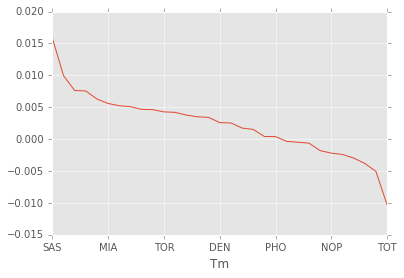

In [59]:
df.groupby(["Tm"]).sum()[focusStat].sort_values(ascending = False).plot()


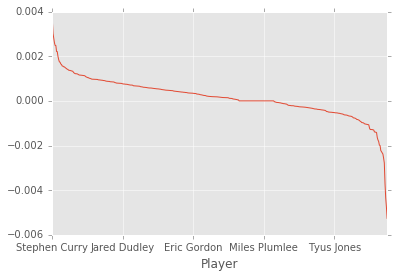

In [60]:
df[focusStat].sort_values(ascending = False).plot()

In [61]:
m = grb.Model()

In [62]:
player_assigned_to_team = {}
for t in Teams:
    for p in Players:
        player_assigned_to_team[p,t] = \
        m.addVar(vtype=grb.GRB.BINARY, 
                 name="player_{}_assigned_to_team_{}".format(p,t))

In [63]:
team_rating = {}
for t in Teams:
    m.addVar(vtype=grb.GRB.CONTINUOUS,
            name="total_VORP_of_team_{}".format(t))


In [64]:
min_team_rating = {}
min_team_rating = m.addVar(vtype=grb.GRB.CONTINUOUS,
                          name="minimum_team_rating")

In [65]:
max_team_rating = {}
max_team_rating = m.addVar(vtype=grb.GRB.CONTINUOUS,
                          name="maximum_team_rating")

In [66]:
m.update()

In [67]:
df["VORP"]["Stephen Curry"]

9.8000000000000007

In [68]:
# Calculate min, max team ratings
for t in Teams:
    m.addConstr(sum(player_assigned_to_team[p,t]*df[focusStat][p] for p in Players)
               >= min_team_rating,
               name="min_rating_greater_than_team_{}".format(t))
    m.addConstr(sum(player_assigned_to_team[p,t]*df[focusStat][p] for p in Players)
               <= max_team_rating,
               name="max_rating_greater_than_team_{}".format(t))

In [69]:
# Each player must be assigned to a 1 and only 1 team
for p in Players:
    m.addConstr(sum(player_assigned_to_team[p,t] for t in Teams)==1,
               name="player_{}_may_only_be_on_one_team".format(p))

In [70]:
# Each team must have between 13 and 17 players
max_team_size = 17
min_team_size = 13

for t in Teams:
    m.addConstr(sum(player_assigned_to_team[p,t] for p in Players)
               >= min_team_size,
               name="team_{}_must_have_min_team_size".format(t))
    m.addConstr(sum(player_assigned_to_team[p,t] for p in Players)
               <= max_team_size,
               name="team_{}_must_have_max_team_size".format(t))

In [71]:
# each team must have this many of each position
# OK so Channing Frye is a PF-C and Sonny Weems is a SG-SF.
# Changing to PF and SG to make this easier

In [72]:
min_players_by_position = {}
min_players_by_position["PG"] = 2
min_players_by_position["SG"] = 2
min_players_by_position["SF"] = 2
min_players_by_position["PF"] = 2
min_players_by_position["C"] = 2

In [73]:
df["Pos"].loc["LeBron James"]

'SF'

In [74]:
pos_dict = df["Pos"].to_dict()

In [75]:
pos_dict["LeBron James"] == "PG"

False

In [76]:
for pos in min_players_by_position:
    for t in Teams:
        m.addConstr(sum(player_assigned_to_team[p,t] for p in Players
                                                if pos_dict[p] == pos)
                   >= min_players_by_position[pos],
                name="team_{}_must_have_atleast_{}_{}".format(t,
                                               min_players_by_position[pos],
                                                             p))


In [77]:
def thisPlayerOnTeam(p,t):
    if(player_cur_team[p] == t):
        ret = 1
    else:
        ret = 0
    return ret

In [78]:
thisPlayerOnTeam("LeBron James","ATL")

0

In [79]:
totalTrades = m.addVar(vtype=grb.GRB.CONTINUOUS, name='total num of trades')

In [80]:
m.update()

In [81]:
# calculate the sum total of player change
m.addConstr(sum(player_assigned_to_team[p,t]*thisPlayerOnTeam(p,t)
               for p in Players for t in Teams),grb.GRB.EQUAL, totalTrades,
               name="Total trades between teams")

<gurobi.Constr *Awaiting Model Update*>

In [82]:
# stipulate max team threshold
max_threshold = 0.001
m.addConstr(max_team_rating - min_team_rating <= max_threshold,
           name='force max threshold')

<gurobi.Constr *Awaiting Model Update*>

In [83]:
m.update()

In [84]:
m.setObjective(totalTrades)
m.ModelSense = grb.GRB.MAXIMIZE

In [85]:
#m.tune()

In [86]:
m.params.mipgap = 0.01
#m.params.symmetry = -1

Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001


In [87]:
m.optimize()

Optimize a model with 748 rows, 14313 columns and 83169 nonzeros
Coefficient statistics:
  Matrix range    [4e-05, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e-03, 2e+01]
Found heuristic solution: objective 12
Presolve removed 2 rows and 32 columns
Presolve time: 0.17s
Presolved: 746 rows, 14281 columns, 82740 nonzeros
Variable types: 1 continuous, 14280 integer (14280 binary)

Root relaxation: objective 4.161949e+02, 3230 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  416.19487    0   55   12.00000  416.19487  3368%     -    0s
H    0     0                     407.0000000  416.19487  2.26%     -    2s
H    0     0                     412.0000000  416.19487  1.02%     -    2s
     0     0  416.06365    0   62  412.00000  416.06365  0.99%     -    2s

Cutting planes:
  MIR: 22
  GUB cover: 3

Exp

In [88]:
sol_player_assigned_to_team = {}
sol_player_assigned_to_team =\
        m.getAttr('X',player_assigned_to_team)

In [89]:
sol_player_assigned_to_team

{('C.J. Watson', 'UTA'): -0.0,
 ('Chris Andersen', 'MIN'): 0.0,
 ('Serge Ibaka', 'ORL'): 0.0,
 ('Jodie Meeks', 'LAC'): -0.0,
 ('Kawhi Leonard', 'PHO'): 0.0,
 ('Jerami Grant', 'BRK'): 0.0,
 ('Jeff Green', 'MIA'): 0.0,
 ('T.J. Warren', 'IND'): 0.0,
 ('Cory Joseph', 'BOS'): 0.0,
 ('Terrence Jones', 'CHO'): 0.0,
 ('Elfrid Payton', 'UTA'): 0.0,
 ('Trey Burke', 'SAC'): -0.0,
 ('Nate Robinson', 'HOU'): 0.0,
 ('Willie Reed', 'LAC'): -0.0,
 ('Paul Millsap', 'MIL'): 0.0,
 ('Carl Landry', 'LAC'): 0.0,
 ('Briante Weber', 'DAL'): -0.0,
 ('Thaddeus Young', 'OKC'): 0.0,
 ('DeJuan Blair', 'POR'): -0.0,
 ('Jared Cunningham', 'GSW'): 0.0,
 ('Mike Miller', 'WAS'): 0.0,
 ('Jimmer Fredette', 'NYK'): 0.0,
 ('Jordan McRae', 'BRK'): 0.0,
 ('Axel Toupane', 'UTA'): -0.0,
 ('Jose Calderon', 'WAS'): 0.0,
 ('Kyle Singler', 'UTA'): 0.0,
 ('Donald Sloan', 'WAS'): 0.0,
 ('David Lee', 'NYK'): 0.0,
 ('Tobias Harris', 'POR'): 0.0,
 ('Leandro Barbosa', 'POR'): 0.0,
 ('Omer Asik', 'LAL'): 0.0,
 ('Anthony Davis', 'DAL'): 0

In [90]:
min_team_rating
#sol_min_team_rating = m.getAttr('X',min_team_rating)
#sol_min_team_rating

<gurobi.Var minimum_team_rating (value 0.0017648010645105842)>

In [91]:
max_team_rating

<gurobi.Var maximum_team_rating (value 0.0027648010645105843)>

In [92]:
sol_player_assignment = {}
for k,v in sol_player_assigned_to_team.items():
    if sol_player_assigned_to_team[k[0],k[1]] == 1:
        sol_player_assignment[k[0]] = k[1]
        print(k[0]+" : "+k[1])

James Young : BOS
Austin Rivers : LAC
Lou Amundson : NYK
Justin Holiday : BOS
Ty Lawson : CHI
Blake Griffin : LAC
Damian Lillard : POR
Kyle Lowry : TOR
Nikola Mirotic : CHI
Greivis Vasquez : MIL
Rasual Butler : SAS
Leandro Barbosa : GSW
Norman Powell : TOR
Steve Blake : DET
Russ Smith : MEM
Jared Sullinger : BOS
Walter Tavares : ATL
Jeremy Evans : DAL
Amar'e Stoudemire : MIA
JaKarr Sampson : CHO
Ish Smith : WAS
Jose Calderon : NYK
Christian Wood : PHI
Darren Collison : SAC
Gerald Henderson : POR
Anderson Varejao : ATL
Andrew Bogut : GSW
Dwight Howard : HOU
Elton Brand : PHI
Carl Landry : PHI
Devyn Marble : ORL
Nikola Pekovic : MIN
Lucas Nogueira : TOR
Jonas Valanciunas : TOR
Ryan Kelly : LAL
David Lee : MIN
Rashad Vaughn : MIL
Sasha Vujacic : NYK
Thanasis Antetokounmpo : NYK
Quincy Acy : SAC
Mike Scott : ATL
Duje Dukan : SAC
Jared Cunningham : CHO
Jodie Meeks : DET
Greg Monroe : MIL
Michael Kidd-Gilchrist : CHO
Glenn Robinson : IND
Victor Oladipo : ORL
Joseph Young : IND
Hollis Thompso

In [93]:
sol_player_assignment

{'Aaron Brooks': 'CHI',
 'Aaron Gordon': 'ORL',
 'Aaron Harrison': 'CHO',
 'Adreian Payne': 'MIN',
 'Al Horford': 'ATL',
 'Al Jefferson': 'CHO',
 'Al-Farouq Aminu': 'POR',
 'Alan Anderson': 'WAS',
 'Alan Williams': 'PHO',
 'Alec Burks': 'UTA',
 'Alex Len': 'PHO',
 'Alex Stepheson': 'OKC',
 'Alexis Ajinca': 'NOP',
 'Allen Crabbe': 'POR',
 'Alonzo Gee': 'NOP',
 "Amar'e Stoudemire": 'MIA',
 'Amir Johnson': 'BOS',
 'Anderson Varejao': 'ATL',
 'Andre Drummond': 'DET',
 'Andre Iguodala': 'GSW',
 'Andre Miller': 'LAC',
 'Andre Roberson': 'OKC',
 'Andrea Bargnani': 'BRK',
 'Andrew Bogut': 'GSW',
 'Andrew Goudelock': 'HOU',
 'Andrew Nicholson': 'ORL',
 'Andrew Wiggins': 'MIN',
 'Anthony Bennett': 'TOR',
 'Anthony Brown': 'LAL',
 'Anthony Davis': 'NOP',
 'Anthony Morrow': 'OKC',
 'Anthony Tolliver': 'DET',
 'Archie Goodwin': 'PHO',
 'Aron Baynes': 'DET',
 'Arron Afflalo': 'NYK',
 'Austin Rivers': 'LAC',
 'Avery Bradley': 'BOS',
 'Axel Toupane': 'DEN',
 'Ben McLemore': 'SAC',
 'Beno Udrih': 'CLE'

In [94]:
df["NewTeam"] = ""

In [95]:
for p,t in sol_player_assignment.items():
    df["NewTeam"].loc[p]= t


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
df["NewTeam"].head()

Player
Stephen Curry        LAL
Russell Westbrook    MIL
LeBron James         PHI
Kawhi Leonard        BRK
Kevin Durant         OKC
Name: NewTeam, dtype: object

In [97]:
df["NewTeam"][df.NewTeam == "PHI"]

Player
LeBron James        PHI
Nerlens Noel        PHI
Channing Frye       PHI
Ersan Ilyasova      PHI
Robert Covington    PHI
Carl Landry         PHI
Richaun Holmes      PHI
Jerami Grant        PHI
Shelvin Mack        PHI
T.J. McConnell      PHI
Isaiah Canaan       PHI
Hollis Thompson     PHI
Nik Stauskas        PHI
Elton Brand         PHI
Jahlil Okafor       PHI
Christian Wood      PHI
Kendall Marshall    PHI
Name: NewTeam, dtype: object

In [98]:
len(df.index)

476

In [99]:
x = df["NewTeam"]!=df["Tm"]
df[x]

,Rankweighted,Rk,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,VORPpermin,NewTeam
Player,,,,,,,,,,,,,,,,,,,,,
Stephen Curry,1,1,PG,27,GSW,79,2700,31.5,0.669,0.554,...,13.8,4.1,17.9,0.318,12.4,0.1,12.4,9.8,0.003630,LAL
Russell Westbrook,2,2,PG,27,OKC,80,2749,27.6,0.554,0.236,...,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,0.003019,MIL
LeBron James,3,3,SF,31,CLE,76,2709,27.5,0.588,0.199,...,9.6,4.0,13.6,0.242,6.9,2.3,9.1,7.6,0.002805,PHI
Kawhi Leonard,4,7,SF,24,SAS,72,2380,26.0,0.616,0.267,...,8.3,5.5,13.7,0.277,5.5,2.8,8.3,6.2,0.002605,BRK
Chris Paul,6,8,PG,30,LAC,74,2420,26.2,0.575,0.295,...,9.2,3.5,12.7,0.253,7.3,0.5,7.8,6.0,0.002479,LAL
James Ennis,34,184,SF,25,TOT,22,329,17.8,0.621,0.513,...,0.7,0.2,0.9,0.133,3.4,-1.0,2.4,0.4,0.001216,MIL
David Lee,77,138,PF,32,TOT,55,903,19.6,0.568,0.003,...,1.7,1.4,3.0,0.161,-0.3,1.7,1.4,0.8,0.000886,MIN
Mario Chalmers,81,110,PG,29,TOT,61,1373,17.2,0.561,0.336,...,2.2,1.5,3.8,0.131,1.7,-0.3,1.5,1.2,0.000874,MIN
Tobias Harris,102,61,PF,23,TOT,76,2513,16.2,0.560,0.269,...,4.1,2.5,6.6,0.126,0.7,0.4,1.0,1.9,0.000756,MEM
